# Macro III - Problem Set 03: Huggett Model (Huggett, 1993, JEDC)

Vinícius de Almeida Nery Ferreira

September 13th, 2024

*NOTE:* in addition to the Problem Set, I also uploaded a file that uses the same code with Huggett's/Tiago's parameters to see if the results matched theirs.

They were pretty close, but I discuss them more in detail in letters ***(d)*** and ***(e)***, as well as in the *Huggett.ipynb* file itself.

In [1]:
# Importing packages
## Data
import numpy as np
import pandas as pd

## Plots
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')

## Other
import random
import time
from tqdm import tqdm

# Setting seeds for random
random.seed(121019)
np.random.seed(121019)

In the model of Huggett, the starting point is a standard bond economy, where households choose consumption and how much to invest in bonds.
Each period lasts two months.

However, we **don't have complete markets**: agents are hit by idiosyncratic shocks that are only *partially insurable*.

That is, the bonds they trade are not state-contingent, and so we have incomplete markets (we don't have a bond for each possible period-state pair: there are many more goods than states).

This leads to ex-ante identical agents being **heterogenous ex-post**.

The household's problem is 

$$
\max_{\{c_t, a_{t+1}\}_{t=0}^{\infty}} \mathbb{E}_0 \sum_{t=0}^{\infty} \beta^t u(c_t),
$$

subject to

$$
\begin{cases}
c_t + q \cdot a_{t+1} = z_t + a_t, \quad c \geq 0 \\
z \sim \text{a Markov Process.}
\end{cases}
$$

where $u(c) = \frac{c^{1-\sigma}}{1-\sigma}$ and $\mathbb{E}_0$ denotes the expected value conditional on the information set at period 0.

$a_t$ denotes bonds/financial assets. 
$z_t$ can be viewed as a labor income shock.
$q_t = \frac{1}{1 + r_t}$ is the bond price, where $r$ is interest rate.

The Bellman Equation of this problem can be written as

$$
V(a, z) = \max_{a'}\left\{u \left( a + z - qa' \right) + \beta \mathbb{E}\left[ V(a', z') | z = \hat{z} \right] \right\}
$$,

where we must conditional on $z = \hat{z}$ since $z$ follows a Markov process.

Furthermore, we stablish an *ad-hoc* borrowing limit, $a' > \underline{a} > -\infty$.
Note that, otherwise, agent would want $a' = -\infty$.

Finally, note that the Euler Equation of the problem is

$$
u'(c_t) = \beta (1+r_t) \mathbb{E}_t[u'(c_{t+1})]
$$

since marginal gains of consumption today have to equal its marginal costs (in expected value) tomorrow.

Since $u$ satisfies the INADA conditions, note that $\beta (1+r_t) > 1$ implies

$$
u'(c_t) = \beta (1+r_t) \mathbb{E}_t[u'(c_{t+1})] > \mathbb{E}_t[u'(c_{t+1})]
\quad \therefore \quad
\mathbb{E}_t[c_t] < \mathbb{E}_t[u'(c_{t+1})]
$$

This means we would have explosive consumption, which would require explosive savings, which is not possible since number of states is fixed and we are in an infinite horizon that problem.

Huggett shows that, under the borrowing constraint and the assumption that $\beta (1+r_t) \leq 1$, the value function becomes a contraction in the relevant parameter space, and so we can solve it using the Contraction Mapping Theorem.

$$
V(a, z) = \max_{\underline{a} < a'< \overline{a}}\left\{u \left( a + z - qa' \right) + \beta \mathbb{E}\left[ V(a', z') | z = \hat{z} \right] \right\}
$$

## Fixed Interest Rate

We will solve the model for a fixed value of $r$, which doesn't necessarily clear the domestic bond market.

We can think of this as a small open economy whose agents can trade bonds with the external sector.

Following Huggett's original paper, suppose we have $N = 2$ states for $z$: unemployed and employed.
In each of them, individuals earn wages if employed or some kind of unemployed insurance / side-gig when unemployed.

We also use the same transition matrix they use, as well as other parameter values.

### (a) Optimal Decision Rule

#### Parameters

In [2]:
# Parameters (period length is two months)
beta = 0.96 ** (1 / 6)
sigma = 1.5
T = 10000

# Printing value of beta per period
print(f"Intertemporal discount factor per period: {round(beta, 5)}")

Intertemporal discount factor per period: 0.99322


In [3]:
# Income grid
## Shock states: employed or unemployed
num_states_shock = 2

## Income of each state (employed - unemployed)
income_grid = np.array([1, 0.1])

In [4]:
# Transition matrix
transition_matrix = np.array([[0.925, 0.075], [0.5, 0.5]])

# Printing transition matrix
print(np.around(transition_matrix, 3))

[[0.925 0.075]
 [0.5   0.5  ]]


#### Stationary Variables

To calculate average income and unemployment duration on the stationary equilibrium, we need to find the percentage of each type of agent - employed or unemployed - that exists in equilibrium.

To do this, we equate flows of employment to unemployment.
The flow of employment to unemployment is

$$
(1-u) \cdot \pi(e_l | e_h),
$$

where $u$ is the unemployment rate and $\pi(e_l | e_h)$ is the separation rate, which is equal to $1 - \pi(e_h | e_h) = 0.075$ in Huggett's model.

The flow of unemployment to employment is

$$
u \cdot \pi(e_h | e_l)
$$,

where $\pi(e_h | e_l) = 0.5$ is the chance of finding a job in Huggett's model.

Equating these quantities, we get the stationary unemployment rate:

$$
(1-u) \cdot \pi(e_l | e_h) = u \cdot \pi(e_h | e_l)
\quad \therefore \quad 
u = \frac{\pi(e_l | e_h)}{\pi(e_l | e_h) + \pi(e_h | e_l)}
$$

Recall that the transition matrix is given by

$$
P =
\begin{bmatrix}
\pi(e_h | e_h) & \pi(e_l | e_h) \\
\pi(e_h | e_l) & \pi(e_l | e_l)
\end{bmatrix}
$$

In [5]:
# Calculating equilibrium unemployment
u = transition_matrix[0, 1] / (transition_matrix[0, 1] + transition_matrix[1, 0])

print(f"Stationary Unemployment Rate: {round(100 * u, 2)}%.")

Stationary Unemployment Rate: 13.04%.


In [6]:
# The average income of a period in the stationary equilibrium will be
avg_income = ((1 - u) * income_grid[0]) + (u * income_grid[1])

print(f"Stationary Average Income per Period: {round(avg_income, 2)}.")
print(f"Stationary Average Yearly Income: {round(6 * avg_income, 2)}.")

Stationary Average Income per Period: 0.88.
Stationary Average Yearly Income: 5.3.


If we look at Huggett's paper (beginning of Section 5), 5.3 is exactly the number he gets for the yearly average income.

In [7]:
# Average unemployment duration
avg_u_duration = 1 / transition_matrix[1, 0]

print(f"Stationary Average Unemployment Duration: {round(avg_u_duration, 2)} periods.")

Stationary Average Unemployment Duration: 2.0 periods.


#### Asset Grid and Interest Rate

We will now define the borrowing constraint and the grid for asset holdings.

In [8]:
# Asset grid
## Ad hoc borrowing limits (one period = 2 months)
asset_lb = -avg_income * 6
asset_up = 3 * avg_income * 6

## Equally spaced grid
num_states_assets = 200
asset_grid = np.linspace(asset_lb, asset_up, num_states_assets)

In [9]:
# Printing difference between points
print(f"Distance between points: {round(asset_grid[1] - asset_grid[0], 2)}")

Distance between points: 0.11


In [10]:
# Checking shape of asset grid
asset_grid.shape

(200,)

In [11]:
# Setting interest rate and bond prices (period length is two months)
r_annual = 0.034
r = (1 + r_annual) ** (1 / 6) - 1
q = 1 / (1 + r)

print(f"Interest Rate per period: {round(100 * r, 2)}%")
print(f"Bond price per period: {round(q, 3)}")

Interest Rate per period: 0.56%; Bond price per period: 0.994.


In [12]:
# Dictionaries for parameters
param_dict = {
    'beta': beta,
    'sigma': sigma,
    'r': r,
    'q':q,
    'z': 1,  # assuming agents begin employed
    'T': T
}

#### Solving the Model

We will use the functions we created in the last problem set to iterate over the Value Function with uncertainty.

##### Consumption and Utility Functions

We need to create a consumption and utility matrix conditional on each possible shock (we have 2 in our case: employed or unemployed).
Thus, our shock space is the income grid.

This is because the current shock happens at beginning of the period, and so its current value is known to agents.

On tests, I found that results are a little bit sensitive to the form of the budget constraint (using interest rates or bond prices).
This makes results of item ***(d)*** onwards change by 0.1 to 0.2% in the case of the annual interest rates.

Following Tiago's code and Huggett's original formulation, we opt to go with the formulation with bond prices.

In [13]:
def consumption_asset(a, a_prime, param_dict):
    """ 
    Calculates consumption as a function of assets today, tomorrow and parameters
    """

    # Getting parameters
    income = param_dict['z']
    q = param_dict['q']
    r = param_dict['r']

    # Calculating consumption
    consumption = a + income - q * a_prime  # using bond price
    # consumption = (1 + r) * a + income - a_prime  # using interest rate

    # Consumption has to be positive
    consumption = np.maximum(consumption, 1e-6)

    # Returning
    return consumption

In [14]:
def utility_asset(a, a_prime, param_dict):
    """ 
    Calculates utility as a function of assets today, tomorrow and parameters
    """

    # Getting parameters
    sigma = param_dict['sigma']

    # Calculating consumption
    consumption = consumption_asset(a, a_prime, param_dict)

    # Utility
    return (1 / (1 - sigma)) * consumption ** (1 - sigma)

In [15]:
def get_utility_conditional_on_shock(a, a_prime, param_dict_uncertainty, shock_space):
    """
    Calculates utility matrices as a function of assets today, tomorrow
    and parameters, conditional on each value of employment.
    Returns an array of matrices of utility for each possible combination of a, a_prime and shock
    """
    
    # Number of shocks and capital states
    n_shock_space = shock_space.shape[0]
    n_asset_space = a.shape[0]

    # Array
    conditional_utility_array = np.zeros([n_shock_space, n_asset_space, n_asset_space])

    # Loop to fill arrays
    for index, income in enumerate(shock_space):
        # Filling
        param_dict_uncertainty['z'] = income

        # Calculating consumption and utility
        ## Recall we want a today in the columns and a' tomorrow in the rows, so we transpose at the end
        conditional_utility_array[index] = utility_asset(a, a_prime, param_dict_uncertainty).T

    # Changing back
    param_dict_uncertainty['z'] = 1

    # Returning
    return conditional_utility_array

##### Value Function

Same function from last Problem Set.

In [16]:
def value_function_iteration_uncertainty(a_space, shock_space, shock_transition_matrix,
                                         param_dict, tol=1e-6, max_iter=5000):
    """
    Iterating through vectors (function approximations) until we reach a fixed point conditional on all shocks.
    Ideally, we would pass the utility_capital function an its parameters as arguments to make this more general.
    """

    # Parameters
    beta = param_dict['beta']

    # Assuring spaces are arrays
    a_space = np.array(a_space)
    shock_space = np.array(shock_space)

    # Getting dimensions of matrices and vectors
    num_asset_spaces = a_space.shape[0]
    num_shock_spaces = shock_space.shape[0]

    # Initial guess
    ## Matrix of conditional value functions
    ## V approximates the value function: for every shock and asset combination,
    ## it should give the maximum value attained
    V = np.zeros([num_shock_spaces, num_asset_spaces])
    V_new = np.ones([num_shock_spaces, num_asset_spaces])

    # Creating meshgrid, which give coordinates of a and a'
    a_matrix, a_prime_matrix = np.meshgrid(a_space, a_space)

    # Array with utilities for each possible combination of a, a' and shock value
    ## For each shock value (first dimension), returns a matrix of utility for space tomorrow
    ## in rows (second dimension) and state today in columns (third dimension)
    u_array_conditional_shock = get_utility_conditional_on_shock(
        a=a_matrix, a_prime=a_prime_matrix, 
        shock_space=shock_space, param_dict_uncertainty=param_dict
    )

    # Iterating
    for num_iter in range(max_iter):
        # Calculating matrix of possible values of V: for every state today (column),
        # what is the value of each state tomorrow (row) conditional on each shock

        ## Loop
        for index_shock in range(num_shock_spaces):
            # Expected value tomorrow
            expected_V_tomorrow = shock_transition_matrix[[index_shock]] @ V

            # Transforming into a vector
            expected_V_tomorrow = expected_V_tomorrow[0, :]

            ## Important: in numpy, operations between matrices (first term) and vectors (second term)
            ## are done column-wise. That is, we add B * V(a', z') to each column, which is exactly 
            ## what we want, as rows represent a' (see matrix on slide 27 of Lecture 4)
            matrix_state_values = u_array_conditional_shock[index_shock] + beta * expected_V_tomorrow

            # Calculating maximum value for each state today (columns, axis=1)
            # That is, for each column, we are grabbing the row (next state) which maximizes V for that state
            # (conditional on the productivity shock we are on)
            V_new[index_shock] = np.max(matrix_state_values, axis=1)

        # Checking if we found the fixed point using the sup norm FOR EACH shock
        # That is, we want the loop to stop when all conditions are satisfied
        if np.max(np.abs(V - V_new)) < tol:
            break
        else:
            V = V_new.copy() # this was a pain to discover that .copy() was necessary

    # Assessing convergence
    if num_iter >= max_iter - 1:
        print("Value function did not converge.")

    # Returning: V_new is now a matrix with the first dimension (rows) being the productivity shocks
    return V_new, num_iter

In [17]:
# Calculating the value function
t0 = time.time()
V_matrix, num_iter_value = value_function_iteration_uncertainty(
    a_space=asset_grid, 
    shock_space=income_grid, 
    shock_transition_matrix=transition_matrix, 
    param_dict=param_dict,
    max_iter=5000
)
time_value_iteration = time.time() - t0

In [18]:
# Printing iterations and time
print(f"Number of Asset States: {len(asset_grid)}")
print(f"Number of Shock States: {len(income_grid)}")
print(f"Number of iterations: {num_iter_value}")
print(f"Seconds: {round(time_value_iteration, 2)}")

Number of Asset States: 200
Number of Shock States: 2
Number of iterations: 2145
Seconds: 0.86


##### Policy Function

We now have to find the policy function $a' = g(a, z)$ and $c = g_c(a, a') = g_c(a, g(a, z))$ through the restriction.

We have to do this for each realization of the shock (recall that the current shock happens at the beginning of the period, so it is known).

In [19]:
def policy_function(V, a_space, param_dict):
    """
    Returns a vector (approximation of a function) that, for every state today,
    gives the optimal state tomorrow.
    """
    # Relevant parameters
    beta = param_dict['beta']

    # Creating meshgrid, which give coordinates of a and a'
    a_matrix, a_prime_matrix = np.meshgrid(a_space, a_space)

    # Matrix with utilities for each possible combination of a and a'
    u_matrix = utility_asset(a=a_matrix, a_prime=a_prime_matrix, param_dict=param_dict).T

    # Calculating matrix of values of state tomorrow x state today
    matrix_state_values = u_matrix + beta * V
    
    # Idea: find indexes of values which give the optimal a' given a
    ## For each column (state today), we are finding the (index of) a' which maximizes the value
    ## The only difference from the value iteration is using np.argmax instead of np.max
    optimal_indexes = np.argmax(matrix_state_values, axis=1)

    # Finding the optimal values of a' for each a
    return a_space[optimal_indexes], optimal_indexes

In [20]:
# Getting dimensions
num_shock_spaces = income_grid.shape[0]

# Skeletons
policy_a_matrix = np.zeros([num_shock_spaces, num_states_assets])
policy_indexes_matrix = np.zeros([num_shock_spaces, num_states_assets])

# Looping to calculate policy function for each state
for num_space in range(num_shock_spaces):
    # Updating parameter
    param_dict['z'] = income_grid[num_space]

    # Policy function and indexes
    policy_a_matrix[num_space], policy_indexes_matrix[num_space] = policy_function(
        V=V_matrix[num_space], 
        a_space=asset_grid,
        param_dict=param_dict
    )

# Returning to original state
param_dict['z'] = 1

In [21]:
# Calculating consumption
## Skeleton
policy_c_matrix = np.zeros([num_shock_spaces, num_states_assets])

## Looping
for num_space in range(num_shock_spaces):
    # Updating parameter
    param_dict['z'] = income_grid[num_space]
    
    # Policy function
    policy_c_matrix[num_space] = consumption_asset(
        a=asset_grid,
        a_prime=policy_a_matrix[num_space],
        param_dict=param_dict
    )

# Returning to original state
param_dict['z'] = 1

In [22]:
def plot_policy_uncertainty(a_space, policy_a_matrix, 
                            policy_c_matrix, shock_space, 
                            title="Policy Functions"):
    # Object and title
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Define a colormap for the gradient
    cmap = plt.get_cmap('Accent')
    num_shocks = len(shock_space)
    
    # First graph: a' x a
    for i in range(num_shocks):
        color = cmap(i / num_shocks)
        ax[0].plot(a_space, policy_a_matrix[i, :], 
                   label=f"{shock_space[i]:.2f}", color=color)

    ax[0].plot(a_space, a_space, color='black', linewidth=.5, 
               linestyle='--', label=r"$a = a'$")
    ax[0].set_xlabel(r"State Today ($a$)", fontsize=10)
    ax[0].set_ylabel(r"State Tomorrow ($a'$)", fontsize=10)
    ax[0].set_title('Asset Policy Function', fontsize=12)
    ax[0].grid(True)
    
    # Second graph: c x k
    for i in range(num_shocks):
        color = cmap(i / num_shocks)
        ax[1].plot(a_space, policy_c_matrix[i, :], 
                   label=f"{shock_space[i]:.2f}", color=color)

    ax[1].set_xlabel(r"State Today ($a$)", fontsize=10)
    ax[1].set_ylabel(r"Consumption Today ($c$)", fontsize=10)
    ax[1].set_title('Consumption Policy Function', fontsize=12)
    ax[1].grid(True)

    # Create a common legend at the bottom
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, title=r'Current Income $z_t$',
               loc='lower center', 
               ncol=3, bbox_to_anchor=(0.5, -0.1))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

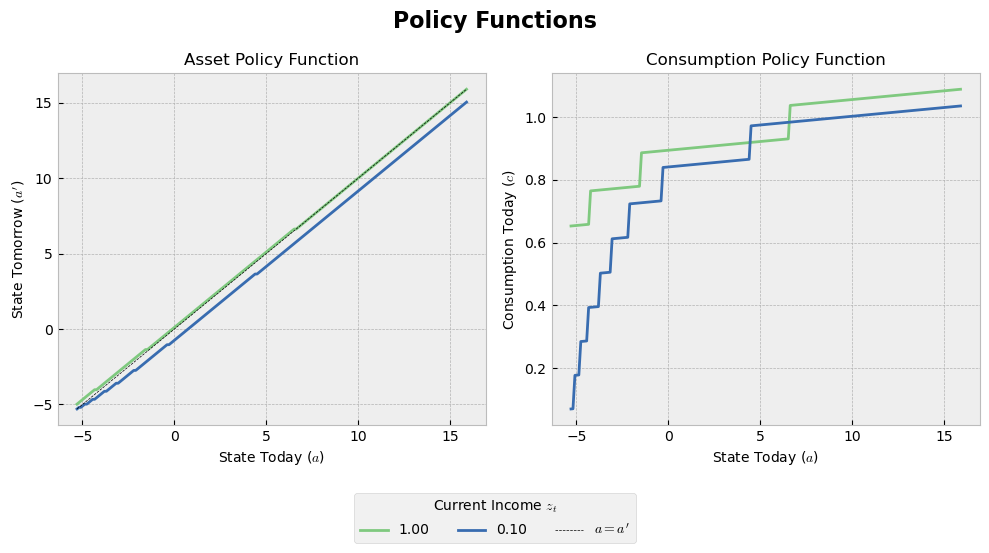

In [23]:
plot_policy_uncertainty(asset_grid, policy_a_matrix, policy_c_matrix, income_grid)

### (b) Simulating the Life of an Individual

Imagine on individual who starts out with no assets, but is hard working and manages to get a job right after finishing school(starts in the state employed/with high endowment).

We will simulate his/her life across 10000 periods (5000 months or almost 417 years, a bit much).

Do we live in the american dream or we have little income mobility? Let's find out!

In [24]:
# Initial parameters
## Starts employed already the default in param_dict

## No assets
initial_assets = 0
cumulative_assets = 0

In [25]:
# Lists
## Assets (wealth)
assets_list = [initial_assets]

## Consumption
consumption_list = []

We first need to simulate the Markov process: we will borrow the functions from the last Problem Set.

In [26]:
def simulate_markov_chain(state_grid, transition_matrix, T,
                          initial_value=None):
    """
    Simulates a Markov chain of length T given the characterization objects
    (state_grid, transition_matrix).
    If passed, initial_value must be an element of state_grid.
    """

    # Getting number of states
    N = state_grid.shape[0]

    # Computing cumulative distribution of the markov chain
    ## Skeleton
    cdf_markov_matrix = np.zeros([N, N])

    ## Looping
    for i in range(N):
        for j in range(N):
            # Summing row i of transition matrix until column j
            cdf_markov_matrix[i, j] = np.sum(transition_matrix[i, :j + 1])
    
    # Skeleton of markov process
    simulated_values = np.zeros(T)

    # Initial state
    ## If not specified, create at random
    if initial_value is None:
        index_state_today = np.random.choice(N)
        state_today = state_grid[index_state_today]
        simulated_values[0] = state_today
    ## If specified, use it as the initial state and grab its index in the grid
    else:
        index_state_today = np.where(state_grid == initial_value)[0][0]
        simulated_values[0] = initial_value

    # Simulating
    for t in range(1, T):
        # Getting random index with probabilities associated to current state
        # transition_matrix[index_state_today]: row i of transition matrix (sums to 1)
        index_state_tomorrow = np.random.choice(
            N, p=transition_matrix[index_state_today]
        )

        # State tomorrow
        state_tomorrow = state_grid[index_state_tomorrow]

        # Adding to array
        simulated_values[t] = state_tomorrow

        # Updating index
        index_state_today = index_state_tomorrow
    
    # Returning simulation
    return simulated_values

In [27]:
# Simulating the chain
simulated_income_markov = simulate_markov_chain(state_grid=income_grid, 
                                                transition_matrix=transition_matrix, 
                                                T=param_dict['T'], 
                                                initial_value=1)

We will now simulate his life.

In [28]:
# Simulating his life
for t in range(T):
    # The idea will be to get the closest value to a(t) in the asset grid 
    # and use this value to calculate the next state a(t+1)
    a_index = np.argmin(np.abs(asset_grid - assets_list[t]))

    # Next period a'
    ## Grabbing what is the value of the current shock
    current_income = simulated_income_markov[t]
    income_index = 0 if current_income == 1 else 1

    ## Adding value of a' to list depending on the current shock
    assets_list.append(policy_a_matrix[income_index, a_index])

    # Consumption
    consumption_list.append(policy_c_matrix[income_index, a_index])

# Arrays
assets_list = np.array(assets_list[1:])
cumulative_assets_list = np.cumsum(assets_list)
consumption_list = np.array(consumption_list)

To plot the values, we will do a rolling average to make things smoother.

In [29]:
# Determning window length
window = 50

# Rolling average (np.ones(window) / window gives the usual weights)
assets_list_smooth = np.convolve(assets_list, np.ones(window) / window, mode='valid')
consumption_list_smooth = np.convolve(consumption_list, np.ones(window) / window, mode='valid')
simulated_income_markov_smooth = np.convolve(simulated_income_markov, np.ones(window) / window, mode='valid')

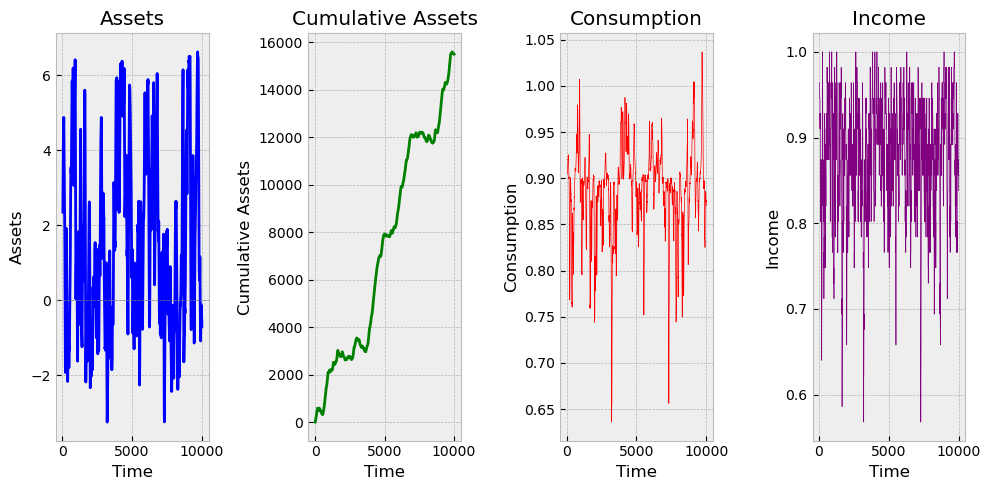

In [30]:
# Creating a 1x4 grid for the line plots of the rolling averages
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# Assets
axs[0].plot(range(window, T + 1), assets_list_smooth, color='b')
axs[0].axhline(0, color='gray', linestyle='--', linewidth=.5)
axs[0].set_title('Assets')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Assets')

# Cumulative assets
axs[1].plot(range(T), cumulative_assets_list, color='g')
axs[1].set_title('Cumulative Assets')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Cumulative Assets')

# Consumption
axs[2].plot(range(window, T + 1), consumption_list_smooth, color='r', linewidth=.5)
axs[2].set_title('Consumption')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Consumption')

# Income
axs[3].plot(range(window, T + 1), simulated_income_markov_smooth, color='purple', linewidth=.5)
axs[3].set_title('Income')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Income')

plt.tight_layout()
plt.show()

Now, we plot the histogram of asset values, with bins being the values in the asset grid.

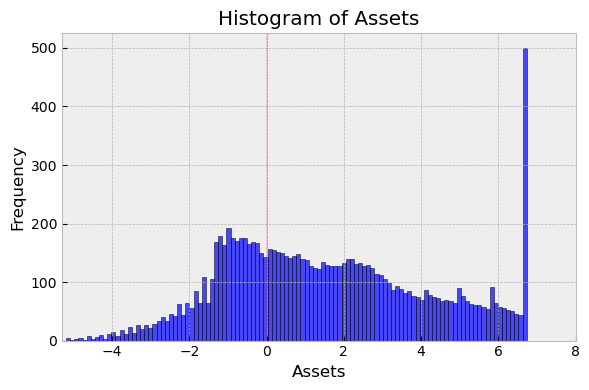

In [31]:
# Plotting the histogram of assets
plt.figure(figsize=(6, 4))
plt.hist(assets_list, bins=asset_grid, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(0, color='red', linestyle='--', linewidth=.33)
plt.xlim(asset_lb, 8)  # for better visualization

plt.title('Histogram of Assets')
plt.xlabel('Assets')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

From the last graph of ***(a)***, we see that we reach a fixed point when the agent is employed (which happens with a higher probability than being unemployed) at the asset value of around 7.

This is reflected in the histogram: once the value of 7 is reached, the agent chooses another asset value only if he/she becomes unemployed, which happens with relatively low probability given the transition matrix.
Thus, the majority of asset choices is precisely the fixed point.

It seems that the american dream is alive and well in Huggett's model.

### (c) Statistics

We are interested in some moments of the last 1,000 periods of the simulation.

#### (a) Average Asset Holding

In [32]:
print(f"Average Asset Holding: {round(np.mean(assets_list[(T - 1000):]), 2)}")

Average Asset Holding: 2.49


#### (b) Average Decline in Consumption in Response to Unemployment

In [33]:
# Getting last 1000 income and consumption values
simulated_income_markov_last1000 = simulated_income_markov[(T - 1000):]
consumption_list_last1000 = consumption_list[(T - 1000):]

# Determining unemployment (employed if earnings == 1)
simulated_unemployment_last1000 = np.array([0 if i == 1 else 1 for i in simulated_income_markov_last1000])

In [34]:
# Lists of consumption before and after an unemployment spell
consumption_before_unemp_list = []
consumption_after_unemp_list = []

# Looping across periods
for t in range(1000):
    # If entered unemployment, calculate consumption today and consumption before
    if simulated_unemployment_last1000[t] == 1 and simulated_unemployment_last1000[t - 1] == 0 and t > 0:
        consumption_before_unemp_list.append(consumption_list_last1000[t - 1])
        consumption_after_unemp_list.append(consumption_list_last1000[t])

# Transforming to arrays
consumption_before_unemp_list = np.array(consumption_before_unemp_list)
consumption_after_unemp_list = np.array(consumption_after_unemp_list)

In [35]:
# Calculating quantities
fall_consumption_absolute = consumption_after_unemp_list - consumption_before_unemp_list
fall_consumption_relative = fall_consumption_absolute / consumption_before_unemp_list

In [36]:
# Printing results
print(f"Average consumption decline in response to unemployment: {round(np.mean(fall_consumption_absolute), 2)}")
print(f"Average consumption percentage decline in response to unemployment: {round(100 * np.mean(fall_consumption_relative), 2)}%")

Average consumption decline in response to unemployment: -0.06
Average consumption percentage decline in response to unemployment: -6.34%


#### (c) Average Value for Consumption in Different States

##### Employed

In [37]:
# Result
average_consumption_employed = np.mean(consumption_list_last1000, where=simulated_unemployment_last1000==0)
print(f"Average Consumption when Employed: {round(average_consumption_employed, 2)}")

Average Consumption when Employed: 0.92


##### Unemployed

In [38]:
# Result
average_consumption_unemployed = np.mean(consumption_list_last1000, where=simulated_unemployment_last1000==1)
print(f"Average Consumption when Unemployed: {round(average_consumption_unemployed, 2)}")

Average Consumption when Unemployed: 0.84


##### Unemployed in Last 6 Periods (12 Months)

In [39]:
# Skeleton
simulated_unemployment6_last1000 = [0 for i in range(1000)]

# Determining in what periods agent has been unemployed for 6 consecutive periods
for t in range(5, 1000):
    # Sum of unemployment values; recall that slices in Python are of the form [, )
    number_months_unemployed_last6 = np.sum(simulated_unemployment_last1000[t - 5:t + 1])

    # If they are unemployed in all periods, add 1 to the array
    simulated_unemployment6_last1000[t] = 1 if number_months_unemployed_last6 == 6 else 0

# Transforming to arrays
simulated_unemployment6_last1000 = np.array(simulated_unemployment6_last1000)

In [40]:
# Result
average_consumption_unemployed6 = np.mean(consumption_list_last1000, where=simulated_unemployment6_last1000==1)
print(f"Average Consumption when Unemployed for 6 Periods: {round(average_consumption_unemployed6, 2)}")
print(f"Number of Times when Unemployed for 6 Periods: {np.sum(simulated_unemployment6_last1000)}")

Average Consumption when Unemployed for 6 Periods: 0.64
Number of Times when Unemployed for 6 Periods: 4


We note that the average consumption when unemployed for 6 periods is smaller than the one conditional on being unemployed in just that period, as the agent has borrowed to smooth consumption in earlier periods and must repay the debt, leaving a smaller space for consumption itself in the budget constraint.

Alternatively, one can smooth the shock of unemployment during just one period through asset buying in the previous period, which is not possible when unemployed for a longer period of time.

#### (d) Correlations

In [41]:
# Assets of last 1000 periods
assets_list_last1000 = assets_list[(T - 1000):]

We need to calculate the total income of the individual, which is the bond earnings and the labor income, i.e., $z_t + a_t$.

In [42]:
# Calculating total earnings (income on the budget constraint)
total_income_last1000 = simulated_income_markov_last1000 + assets_list_last1000

In [43]:
# Creating a dictionary of the arrays
heatmap_data = {
    "Consumption": consumption_list_last1000,
    "Assets": assets_list_last1000,
    "Labor Income": simulated_income_markov_last1000,
    "Total Income": total_income_last1000,
}

# Calculating the correlation matrix
correlation_matrix = np.corrcoef([heatmap_data["Consumption"], 
                                  heatmap_data["Assets"],
                                  heatmap_data["Labor Income"], 
                                  heatmap_data["Total Income"]])

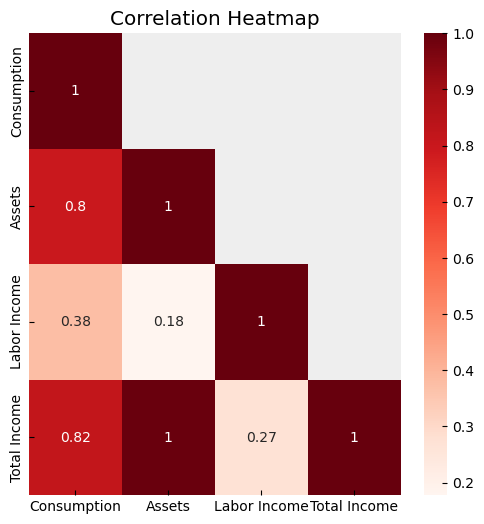

In [45]:
# Exclude the upper triangle of the matrix
# k = 1 keeps the diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Heatmap with correlations
## Object
plt.figure(figsize=(6, 6))

## Heatmap: masking (hiding) upper triangle
sns.heatmap(correlation_matrix, annot=True, cmap="Reds", mask=mask, 
            xticklabels=heatmap_data.keys(), yticklabels=heatmap_data.keys())

## Aesthetics and showing
plt.title("Correlation Heatmap")
plt.grid(False)
plt.show()

The lowest correlation is between labor income and assets.

This can be partially explained by the high correlation between total income and assets: assets make the biggest portion of income, while labor income seems less related to total income.

Consumption is more correlated with total income and less with labor income, with asset values in between.

This is because agents can smooth consumption through asset holding, and so ups and downs in labor income are not reflected as much in variations of consumption.

## Bond Market Clearing

### (d) Solving Huggett's Model

In Huggett's original model, the bond market needs to clear, with the adjustments being made through the interest rate $r$ (or equivalently through the bond price $q$).

Note that, in the previous exercises, we found $a' = g(a, z)$ *conditional on* a value of $r$.

As we have idiosyncratic risk, each individual will be exposed to a diffrent history of shocks, and so can be identified by such history.

Since the history of shocks affects the individual's wealth and they have different histories, there will be a **cross-sectional distribution of assets**: since agents can't fully insure, consumption and asset holding of ex-ante identical agents will be different.

We will denote the distribution of $(a, z)$ at time $t$ as $\lambda_t(a, z)$.

One of our goals is to find a time invariant (or stationary) distribution $\lambda(a, z)$ such that $\lambda_t(a, z) = \lambda_{t+1}(a, z) = \lambda(a, z)$.
Under the *monotonic mixing condition*, we know that such a distribution exists and is unique.

Note that, even if aggregates are constant, individual-specific variables are not: the distribution is the same, but the individuals occupying each position are not.

Agents jumpy frequently around the distribution, but in such a way that aggregates don't change (in the stationary distribution $\lambda(a, z)$).

Furthermore, since $\lambda(a, z)$ does not change, the optimal household decision yields a constant excess-demand for bonds given a constant interest-rate: we "just" need to find the rate such that the bond market clears.

Formally, we have that a ***stationary equilibrium*** is an interest rate, $r$, a policy function, $g(a,z)$, and a stationary distribution $\lambda(a,z)$, such that:

1. The policy function $g(a,z)$ solves $V(a,z)$;
2. The bond market clears:

$$
\sum_{z,a} \lambda(a,z) g(a,z) = 0 \quad \left(\text{or } \sum_{z,a} \lambda(a,z) g_c(a,z) = w \right).
$$

3. The stationary distribution $\lambda(a,z)$ is induced by $(P,z)$ and $g(a,z)$:

$$
\lambda(B) = \sum_{X = [a,\bar{a}] \times Z \in B} Q(X,B).
$$,

where $P$ is the transition matrix of the Markov process $z$.

To find such an interest, we will implement the following algorithm:

1. Guess $r = r_j$

2. Solve household’s problem using dynamic programming to find $g_j(a,z)$ and find $\lambda_j(a,z)$

3. Compute the aggregate excess demand for bonds:
$$
e = \sum_{z,a} \lambda_j(a,z)g_j(a,z)
$$

4. If $e > \varepsilon$, we have too much savings, so we need to make it less atractive. Thus, update $r_{j+1} < r_j$ (if $e < \varepsilon$, update $r_{j+1} > r_j$) and go back to step (1). 
If $|e| < \varepsilon$, stop.

#### Endogenous Markov Chain

To calculate the cross-sectional distribution, we will use the **discretization** approach, approximating the distribution function on a discrete number of asset points.

This will be done using the grid we constructed for the first exercises.

Note that our distribution depends on $a$ and $z$, where $a$ is endogeneous.
Thus, we have to create a endogenous markov chain and find a fixed point for it.

Denoting by $M$ the number of assets in the grid and by $N$ the number of states, we will have a $MN \times MN$ transition matrix.

We will follow the steps that start in Slide 39 of Lecture 6.

First, we need to convert our policy functions to (binary) transition matrices, with one matrix for each state.

The element $ij$ of each matrix indicates if the next state $j$ is the optimal state to be in given the state today $i$, conditional on the value of the shock.

In [46]:
# Skeleton of array
policy_transition_matrices = np.zeros([num_states_shock, num_states_assets, num_states_assets])

# Looping to fill
for index_shock in range(num_states_shock):
    for state_today in range(num_states_assets):
        # Optimal state to be in tomorrow given state today and shocl
        optimal_state_tomorrow = int(policy_indexes_matrix[index_shock, state_today])

        # Filling matrix
        policy_transition_matrices[index_shock, state_today, optimal_state_tomorrow] = 1

In [47]:
# Transforming into a function for the loop
def get_policy_transition_matrices(policy_indexes_matrix, num_states_shock, num_states_assets):
    # Skeleton of array
    policy_transition_matrices = np.zeros([num_states_shock, num_states_assets, num_states_assets])

    # Looping to fill
    for index_shock in range(num_states_shock):
        for state_today in range(num_states_assets):
            # Optimal state to be in tomorrow given state today and shock
            optimal_state_tomorrow = int(policy_indexes_matrix[index_shock, state_today])

            # Filling matrix
            policy_transition_matrices[index_shock, state_today, optimal_state_tomorrow] = 1
    
    # Returning the policy transition array
    return policy_transition_matrices

We now create the block matrix that is the endogenous Markov Chain.

That is, denoting by $M_g$ the transition matrix of assets in the good state (being employed) and by $M_b$ the one in the bad state, we have 

$$
M = 
\begin{bmatrix}
\pi(e_h | e_h) \cdot M_g & \pi(e_l | e_h) \cdot M_g \\
\pi(e_h | e_l) \cdot M_b & \pi(e_l | e_l) \cdot M_b
\end{bmatrix},
$$

where 

$$
P =
\begin{bmatrix}
\pi(e_h | e_h) & \pi(e_l | e_h) \\
\pi(e_h | e_l) & \pi(e_l | e_l)
\end{bmatrix}
$$

is the (exogenous) transition matrix of shocks.
Note that $\pi(e_h | e_h) = 0.925$ and $\pi(e_l | e_l) = 0.5$ in our example.

Note that the relevant policy function is the one in the current state.
Furthermore, each row of $M$ sums to one.

In [48]:
# Skeleton of array
endogenous_transition_matrix = np.zeros([num_states_assets * num_states_shock,
                                         num_states_assets * num_states_shock])

# Filling the matrix
for state_shock_today in range(num_states_shock):
    # Initial and final indexes that delimit each "quadrant"
    # Recall that each "row" (group of rows) denotes the state today
    initial_index_row = state_shock_today * num_states_assets
    final_index_row = (state_shock_today + 1) * num_states_assets

    for state_shock_tomorrow in range(num_states_shock):
        # Initial and final indexes that delimit each "quadrant"
        # Recall that each "column" (group of column) denotes the state today
        initial_index_col = state_shock_tomorrow * num_states_assets
        final_index_col = (state_shock_tomorrow + 1) * num_states_assets

        # Filling the quadrabt of the matrix that corresponds to 
        # state_today x state_tomorrow
        endogenous_transition_matrix[initial_index_row:final_index_row, 
                                     initial_index_col:final_index_col] = \
            transition_matrix[state_shock_today, state_shock_tomorrow] * \
            policy_transition_matrices[state_shock_today]

In [49]:
# Seeing if each row sums to 1: all good!
np.allclose(np.ones(num_states_assets * num_states_shock),
            np.sum(endogenous_transition_matrix, axis=1))

True

In [50]:
# Creating function
def get_endogenous_transition_matrix(policy_transition_matrices, exog_transition_matrix,
                                     num_states_shock, num_states_assets):
    # Skeleton of array
    endogenous_transition_matrix = np.zeros([num_states_assets * num_states_shock,
                                            num_states_assets * num_states_shock])

    # Filling the matrix
    for state_shock_today in range(num_states_shock):
        # Initial and final indexes that delimit each "quadrant"
        # Recall that each "row" (group of rows) denotes the state today
        initial_index_row = state_shock_today * num_states_assets
        final_index_row = (state_shock_today + 1) * num_states_assets

        for state_shock_tomorrow in range(num_states_shock):
            # Initial and final indexes that delimit each "quadrant"
            # Recall that each "column" (group of column) denotes the state today
            initial_index_col = state_shock_tomorrow * num_states_assets
            final_index_col = (state_shock_tomorrow + 1) * num_states_assets

            # Filling the quadrabt of the matrix that corresponds to 
            # state_today x state_tomorrow
            endogenous_transition_matrix[initial_index_row:final_index_row, 
                                        initial_index_col:final_index_col] = \
                exog_transition_matrix[state_shock_today, state_shock_tomorrow] * \
                policy_transition_matrices[state_shock_today]
    
    # Returning the matrix
    return endogenous_transition_matrix

#### Stationary Distribution

We will approximate the stationary distribution by simulating its motion law across a large number of periods.
If we arrive at a distribution that doesn't change much between iterations, we found our stationary distribution.

This is given in Slides 34 and 35 of Lecture 6.

In [51]:
def get_stationary_distribution(endogenous_transition_matrix, max_iter=5000, tol=1e-6):
    # Getting number of shocks * assets
    dimension = endogenous_transition_matrix.shape[0]

    # Initial unconditional distribution: everyone has equal assets
    # "everyone": everyone in all possible assets x shocks pairs
    lambda_today = np.ones([1, dimension]) / dimension

    # Simulating distribution
    for num_iter in range(max_iter):
        # Calculating distribution of next period (vT in the slides)
        lambda_tomorrow = lambda_today @ endogenous_transition_matrix

        # Seeing if the distributions are close, i.e., if we found the stationary one
        if np.max(np.abs(lambda_today - lambda_tomorrow)) < tol:
            break
        else:
            lambda_today = lambda_tomorrow.copy()
    
    # Assessing convergence
    if num_iter >= max_iter - 1:
        print("Stationary distribution was not found.")
    
    # Returning vector of the stationary distribution
    return lambda_tomorrow

In [52]:
# Example with the fixed interest rate
stationary_distribution = get_stationary_distribution(endogenous_transition_matrix)

In [123]:
# Sum: all good!
np.around(np.sum(stationary_distribution), 6)

1.0

#### Market Clearing

Will check the excess demand for bonds, which is given by the net demands for $a'$ (recall that $a_t$ is chosen in $t-1$).

This is given in Slides 43 and 44 of Lecture 6.

In [54]:
def get_excess_demand_bonds(stationary_distribution, policy_a_matrix):
    """
    The stationary distribution is a 1 x (N_shocks * N_assets) vector,
    while policy_a_matrix is a N_shocks x N_assets matrix
    """

    # Getting dimensions
    num_states_shock = policy_a_matrix.shape[0]
    num_states_assets = policy_a_matrix.shape[1]
    dimension = num_states_shock * num_states_assets

    # Calculating excess demand
    ## Skeleton
    excess_demand_vector = np.zeros(dimension)

    ## Looping
    for shock_today in range(num_states_shock):
        for state_today in range(num_states_assets):
            # Calculating index
            index_state_shock = int(shock_today * num_states_assets + state_today)

            # Calculating excess demand for that pair (a, z)
            excess_demand_vector[index_state_shock] = \
                stationary_distribution[0, index_state_shock] * \
                policy_a_matrix[shock_today, state_today]

    # Calculating excess demand
    # excess_demand_bonds = np.dot(stationary_distribution[0], policy_a_vec[0])
    excess_demand_bonds = np.sum(excess_demand_vector)

    # Returning
    return excess_demand_bonds, excess_demand_vector

To update the interest rate in case of non-convergence, we will use the bisection method, updating at the mid point of the bounds.

In doing so, we assume that the excess demand function for bonds is continuous in $q$ (or in $r$), and that it indeed crosses 0 somewhere along our the interval we specify below.
Although we don't formally show this, it turns out to be true.

#### (a) Putting it All Together

We will now do the whole thing to find what is the optimal interest rate.

Keep in mind that, as in the matlab code, we solve for $q = \frac{1}{1+r}$.
Recall that, in the deteministic case, $q = \frac{1}{1+r} = \beta$.

##### Solving the Model

In [55]:
# Parameters
max_iter_market_clearing = 50
tol_market_clearing = 0.001  # same as Tiago (Huggett: 0.0025)

# Initial parameters for the bisection algorithm
q_lb = beta + tol_market_clearing
q_ub = 1.2
q_guess = (q_lb + q_ub) / 2

In [56]:
# Updating the dictionary of parameters
param_dict_market = {
    'beta': beta,
    'sigma': sigma,
    'r': 1 / q_guess - 1,
    'q':q_guess,
    'z': 1,
    'T': T
}

Since we will solve the problem a lot of times, it is worth to make the solving algorithm a function.

In [57]:
def market_clearing_huggett(
    param_dict_market_clearing,
    q_lb,
    q_ub,
    q_guess,
    asset_grid,
    max_iter_market_clearing=max_iter_market_clearing,
    tol_market_clearing=tol_market_clearing,
    income_grid=income_grid,
    transition_matrix=transition_matrix,
    num_shock_spaces=num_shock_spaces,
    num_states_assets=num_states_assets,
    num_states_shock=num_states_shock
):
    # Placeholder lists for storing excess demand bonds
    excess_demand_bonds_list = []

    for num_iter_market in tqdm(range(max_iter_market_clearing)):
        """
        1. Solve the household's problem with the given parameters
        """
        # Value function
        V_matrix, num_iter_value = value_function_iteration_uncertainty(
            a_space=asset_grid, 
            shock_space=income_grid, 
            shock_transition_matrix=transition_matrix, 
            param_dict=param_dict_market_clearing,
            max_iter=5000,
            tol=1e-8
        )

        # Policy function
        policy_a_matrix = np.zeros([num_shock_spaces, num_states_assets])
        policy_indexes_matrix = np.zeros([num_shock_spaces, num_states_assets])
        policy_c_matrix = np.zeros([num_shock_spaces, num_states_assets])


        # Looping to calculate policy function for each state
        for num_space in range(num_shock_spaces):
            # Updating parameter
            param_dict_market_clearing['z'] = income_grid[num_space]

            # Policy function and indexes
            ## Assets
            policy_a_matrix[num_space], policy_indexes_matrix[num_space] = policy_function(
                V=V_matrix[num_space], 
                a_space=asset_grid,
                param_dict=param_dict_market_clearing
            )

            ## Consumption
            policy_c_matrix[num_space] = consumption_asset(
                a=asset_grid,
                a_prime=policy_a_matrix[num_space],
                param_dict=param_dict_market_clearing
            )

        """
        2. Calculate the endogenous Markov Chain to get the law of motion
        of the unconditional asset distribution of assets and shocks
        """
        policy_transition_matrices = get_policy_transition_matrices(
            policy_indexes_matrix=policy_indexes_matrix,
            num_states_shock=num_states_shock,
            num_states_assets=num_states_assets
        )

        # Getting endogenous transition matrix
        endogenous_transition_matrix = get_endogenous_transition_matrix(
            policy_transition_matrices=policy_transition_matrices,
            exog_transition_matrix=transition_matrix,
            num_states_shock=num_states_shock,
            num_states_assets=num_states_assets
        )

        """
        3. Get the stationary distribution using the endogenous transition matrix
        """
        stationary_distribution = get_stationary_distribution(endogenous_transition_matrix, tol=1e-8)

        """
        4. Calculate excess demand for bonds
        """
        excess_demand_bonds, excess_demand_vector = get_excess_demand_bonds(
            stationary_distribution=stationary_distribution,
            policy_a_matrix=policy_a_matrix
        )

        # Storing result
        excess_demand_bonds_list.append(excess_demand_bonds)

        # Assessing market clearing
        if abs(excess_demand_bonds) < tol_market_clearing:
            break
        else:
            # If we haven't convergence, update the price of bonds
            if excess_demand_bonds > 0:
                q_lb = q_guess
            else:
                q_ub = q_guess
        
        # Assessing improvement
        if num_iter_market > 5:
            if np.mean(excess_demand_bonds_list[(num_iter_market - 5):num_iter_market]) == excess_demand_bonds:
                print(f"Algorithm stopped improving. Stopping at {num_iter_market} iterations.")
                break

        # Mid-point
        q_guess = (q_lb + q_ub) / 2

        # Updating dictionary
        param_dict_market_clearing['r'] = 1 / q_guess - 1
        param_dict_market_clearing['q'] = q_guess

    # Assessing convergence
    if num_iter_market == max_iter_market_clearing - 1:
        print(f"Algorithm did not converge in {num_iter_market + 1} iterations with tolerance {tol_market_clearing}.")

    return param_dict_market_clearing, excess_demand_bonds, excess_demand_vector, \
        policy_a_matrix, policy_c_matrix, stationary_distribution

In [58]:
# Solving the model
t0 = time.time()
param_dict_market, excess_demand_bonds, excess_demand_vector, \
    policy_a_matrix, policy_c_matrix, stationary_distribution \
    = market_clearing_huggett(
        param_dict_market_clearing=param_dict_market,
        q_lb=q_lb, q_ub=q_ub, q_guess=q_guess,
        asset_grid=asset_grid
    )
print(f"{round(time.time() - t0, 1)} seconds to run.")

  0%|          | 0/50 [00:00<?, ?it/s]

 82%|████████▏ | 41/50 [00:22<00:04,  1.84it/s]

Algorithm stopped improving. Stopping at 41 iterations.
22.4 seconds to run.


In [59]:
# Printing excess demand for bonds
print(f"Excess demand for bonds (sum): {round(excess_demand_bonds, 4)}")
print(f"Excess demand for bonds (average): {round(excess_demand_bonds / (num_states_assets * num_states_shock), 4)}")

# print("Excess demand for each state-asset level:")
# np.around(excess_demand_vector, 3)

Excess demand for bonds (sum): 0.0214
Excess demand for bonds (average): 0.0001


In [60]:
# Printing bond price per period and interest rate per period
print(f"Bond price per period: {round(param_dict_market['q'], 4)}")
print(f"Interest rate per period: {round(100 * param_dict_market['r'], 2)}%")

Bond price per period: 0.9957
Interest rate per period: 0.43%


In [124]:
# Annualized interest rate
annual_interest_rate = (1 + param_dict_market['r'])**6 - 1
print(f"Annual interest rate: {round(100 * annual_interest_rate, 2)}%")

Annual interest rate: 2.63%


With the parameters of this problem set, my code failed to converge with the tolerance level specified, but the excess demand for bonds was relatively small ($0.0214$).
Note that this is the sum of assets in all assets-income pairs, not the average, which is 0.0001 (acceptable given our tolerance level).

Taking this as tolerable, the annual interest rate that clears the bond market is $2.63$%.

Given that Huggett finds positive interest rates starting from $\underline{a} = -4$ and we have $\underline{a} = -5.3$, the sign of the rate appears to make sense.

When using the parameters of this problem set, Tiago's code also doesn't converge in 100 iterations (actually more, had to break the loop after a few minutes). 

Using the values of the final iteration. his bond price is 0.9966 and the annual interest rate is 2.06%, with an excess demand for bonds of more than 0.5.

Non-convergence is probably related to the precision required for convergence.
This implies that we would need a finer grid, which we don't have with the parameters of the question.

Indeed, the distance between asset points with $N = 200$ and the bounds based on the yearly average income is about $0.11$, which is big given the precision we need for convergence of the model.

In [62]:
# Printing difference between points
print(f"Distance between points: {round(asset_grid[1] - asset_grid[0], 2)}")

Distance between points: 0.11


---

Using [MatLab Online](https://matlab.mathworks.com/), Tiago's original code gives a bond price of 1.0112 per period and an annual interest rate of -6.49% (per period: -1.11%).

When using the same parameters as his, I get a bond price of 1.0116 per period and an annual interest rate of -6.68% (per period: -1.15%).

Note that this is different from the value in Huggett, which, with a credit limit of -2, gives a bond price of 1.0124 and an annual interest rate of -7.1% (see Table 1).

---

##### Policy Functions

We now plot the policy functions in Huggett's equilibrium.

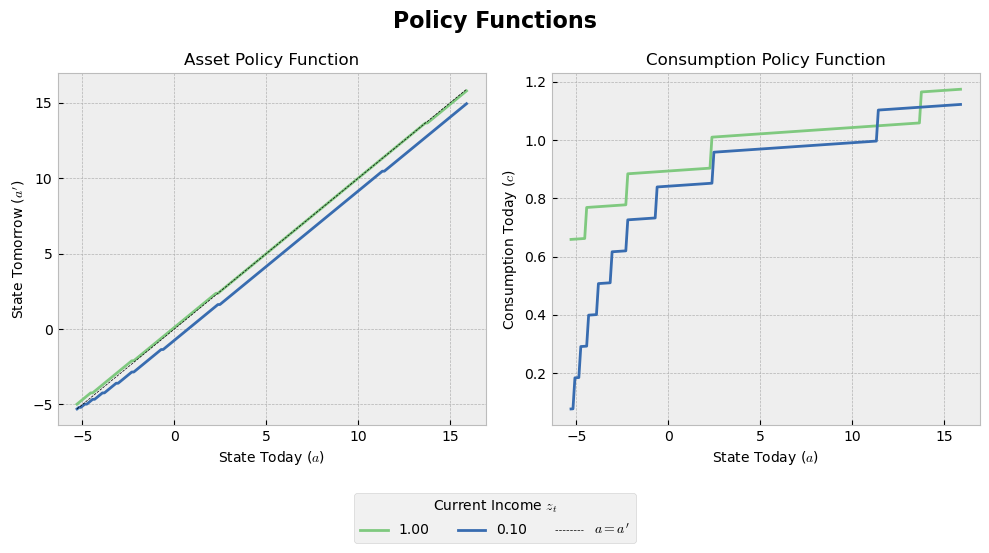

In [63]:
plot_policy_uncertainty(asset_grid, policy_a_matrix, policy_c_matrix, income_grid)

##### Asset Distributions

In [64]:
# Flattening the policy matrix (first the first row, then the row)
# This is because of the way we structured the endogenous transition matrix,
# which was first all assets in the good state, then all assets in bad state.
policy_a_flat = policy_a_matrix.flatten(order='C')

In [65]:
# Sorting following the values of policy a
sorted_indices = np.argsort(policy_a_flat)

sorted_policy_a_flat = policy_a_flat[sorted_indices]
sorted_stationary_distribution = stationary_distribution[0][sorted_indices]

In [66]:
# Calculating the CDF
cdf_stationary_distribution = np.cumsum(sorted_stationary_distribution)

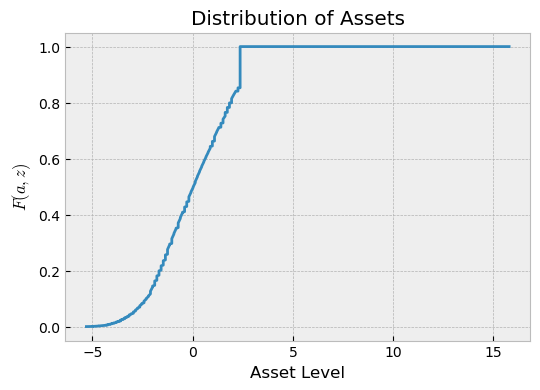

In [67]:
# Plotting
## Object
plt.figure(figsize=(6, 4))

## Plot
plt.plot(sorted_policy_a_flat, cdf_stationary_distribution)

## Labels
plt.xlabel("Asset Level")
plt.ylabel(r"$F(a, z)$")
plt.title("Distribution of Assets")

## Show
plt.grid(True)
plt.show()

We now calculate the Gini coefficient and the standard deviation of asset holdings.

To do so, we will simulate and economy of 10,000 agents that has the same distribution of assets as the stationary one.

In [68]:
# Number of agents
num_agents = 10000

# Array of indexes
array_coefficients_gini_index = np.around(cdf_stationary_distribution * num_agents, 0).astype(int) - 1

# Initializing array
array_assets_agents = np.zeros(num_agents)

# Simulating the distribution
for num_agent in range(num_agents):
    # Grabbing what is the minimum 'quantile' that accomodates that agent
    min_quantile = np.min(array_coefficients_gini_index[array_coefficients_gini_index >= num_agent])
    
    # Index of asset
    min_index = np.where(array_coefficients_gini_index == min_quantile)[0][0]

    # Giving that asset level to agent
    array_assets_agents[num_agent] = sorted_policy_a_flat[min_index]

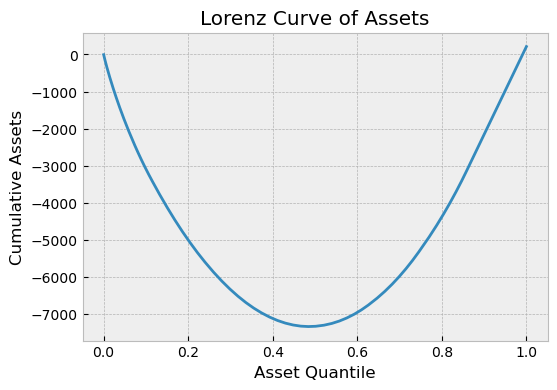

In [69]:
# Calculating Lorenz curve and plotting it
array_assets_lorenz = np.cumsum(array_assets_agents)
cumulative_share_agents = np.cumsum(np.ones(num_agents) / num_agents)

## Object
plt.figure(figsize=(6, 4))

## Plot
plt.plot(cumulative_share_agents, array_assets_lorenz)

## Labels
plt.xlabel("Asset Quantile")
plt.ylabel("Cumulative Assets")
plt.title("Lorenz Curve of Assets")

## Show
plt.grid(True)
plt.show()

To calculate the Gini, I took a function from [StackOverflow](https://stackoverflow.com/questions/39512260/calculating-gini-coefficient-in-python-numpy).

In [70]:
def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""

    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
        
    return diffsum / (len(x)**2 * np.mean(x))

In [71]:
# Calculating Gini coefficient
print(f"Gini coefficient with sigma = {param_dict_market['sigma']}: {round(gini_coefficient(array_assets_agents), 2)}")

Gini coefficient with sigma = 1.5: 46.73


Note that, since we have negative values, the Gini index does not fall into the unit interval.

In [72]:
# Calculating standard deviation
print(f"Standard deviation with sigma = {param_dict_market['sigma']}: {round(np.std(array_assets_agents), 2)}")

Standard deviation with sigma = 1.5: 1.75


#### (b) Simulating the Life of an Individual

Imagine on individual who starts out with no assets, but is hard working and manages to get a job right after finishing school(starts in the state employed/with high endowment).

We will simulate his/her life across 10000 periods (5000 months or almost 417 years, a bit much).

In [73]:
# Initial parameters
## Starts employed already the default in param_dict

## No assets
initial_assets = 0
cumulative_assets = 0

In [74]:
# Lists
## Assets (wealth)
assets_list_market = [initial_assets]

## Consumption
consumption_list_market = []

In [75]:
# Simulating the chain
simulated_income_markov = simulate_markov_chain(state_grid=income_grid, 
                                                transition_matrix=transition_matrix, 
                                                T=param_dict['T'], 
                                                initial_value=1)

We will now simulate his life.

In [76]:
# Simulating his life
for t in range(T):
    # The idea will be to get the closest value to a(t) in the asset grid 
    # and use this value to calculate the next state a(t+1)
    a_index = np.argmin(np.abs(asset_grid - assets_list_market[t]))

    # Next period a'
    ## Grabbing what is the value of the current shock
    current_income = simulated_income_markov[t]
    income_index = 0 if current_income == 1 else 1

    ## Adding value of a' to list depending on the current shock
    assets_list_market.append(policy_a_matrix[income_index, a_index])

    # Consumption
    consumption_list_market.append(policy_c_matrix[income_index, a_index])

# Arrays
assets_list_market = np.array(assets_list_market[1:])
cumulative_assets_list = np.cumsum(assets_list_market)
consumption_list_market = np.array(consumption_list_market)

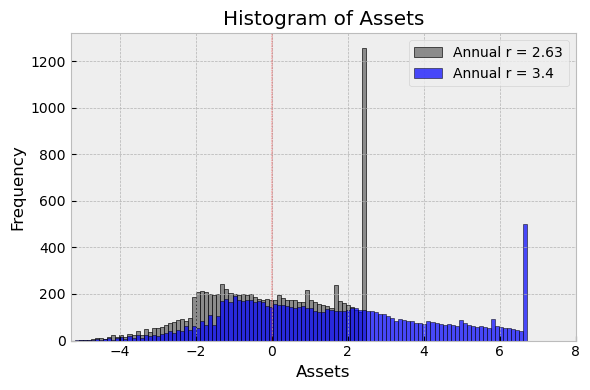

In [77]:
# Plotting the histogram of assets
plt.figure(figsize=(6, 4))
plt.hist(assets_list_market, bins=asset_grid, 
         color='gray', alpha=0.9, edgecolor='black',
         label=f"Annual r = {round(100 * annual_interest_rate, 2)}")

plt.hist(assets_list, bins=asset_grid, 
         color='blue', alpha=0.7, edgecolor='black',
         label=f"Annual r = {round(100 * ((1 + r) ** 6 - 1), 2)}")

plt.axvline(0, color='red', linestyle='--', linewidth=.33)
plt.xlim(asset_lb, 8)

plt.title('Histogram of Assets')
plt.xlabel('Assets')
plt.ylabel('Frequency')

plt.legend()
plt.tight_layout()
plt.show()

The interest rate which (approximately) clears the market is lower than the one we used in the previous set of items ***(a)***.

Thus, agents have a lower incentive to accumulate and buy assets, as their return is lower (i.e., their price is higher in the bond market clearing case).

This also translates to a higher mass below zero, as debts are now cheaper.

#### (c) Statistics

We are interested in some moments of the last 1,000 periods of the simulation.

In [78]:
# Calculating annual interest rates as percentages for displays
annual_interest_rate_previous = round(100 * ((1 + r)**6 - 1), 2)
annual_interest_rate = round(100 * annual_interest_rate, 2)

##### (a) Average Asset Holding

In [79]:
print(f"Average Asset Holding with annual r = {annual_interest_rate_previous}: {round(np.mean(assets_list[(T - 1000):]), 2)}.")
print(f"Average Asset Holding with annual r = {annual_interest_rate}: {round(np.mean(assets_list_market[(T - 1000):]), 2)}.")

Average Asset Holding with annual r = 3.4: 2.49.
Average Asset Holding with annual r = 2.63: 0.07.


As discussed above, the lower interest rate mean that agents have less incentives to hold assets, as their return is lower and debts are cheaper.

##### (b) Average Decline in Consumption in Response to Unemployment

In [80]:
# Getting last 1000 income and consumption values
simulated_income_markov_market_last1000 = simulated_income_markov[(T - 1000):]
consumption_list_market_last1000 = consumption_list_market[(T - 1000):]

# Determining unemployment
simulated_unemployment_market_last1000 = np.array([0 if i == 1 else 1 for i in simulated_income_markov_market_last1000])

In [81]:
# Lists of consumption before and after an unemployment spell
consumption_before_unemp_market_list = []
consumption_after_unemp_market_list = []

# Looping across periods
for t in range(1000):
    # If unemployed, calculate consumption today and consumption before
    if simulated_unemployment_market_last1000[t] == 1 and simulated_unemployment_market_last1000[t - 1] == 0 and t > 0:
        consumption_before_unemp_market_list.append(consumption_list_market_last1000[t - 1])
        consumption_after_unemp_market_list.append(consumption_list_market_last1000[t])

# Transforming to arrays
consumption_before_unemp_market_list = np.array(consumption_before_unemp_market_list)
consumption_after_unemp_market_list = np.array(consumption_after_unemp_market_list)

In [82]:
# Calculating quantities
fall_consumption_absolute_market = consumption_after_unemp_market_list - consumption_before_unemp_market_list
fall_consumption_relative_market = fall_consumption_absolute_market / consumption_before_unemp_market_list

# Printing results
print(f"r = {annual_interest_rate_previous}")
print(f"Average consumption decline in response to unemployment: {round(np.mean(fall_consumption_absolute), 2)}")
print(f"Average consumption percentage decline in response to unemployment: {round(100 * np.mean(fall_consumption_relative), 2)}%")

print(f"\nr = {annual_interest_rate}")
print(f"Average consumption decline in response to unemployment: {round(np.mean(fall_consumption_absolute_market), 2)}")
print(f"Average consumption percentage decline in response to unemployment: {round(100 * np.mean(fall_consumption_relative_market), 2)}%")

r = 3.4
Average consumption decline in response to unemployment: -0.06
Average consumption percentage decline in response to unemployment: -6.34%

r = 2.63
Average consumption decline in response to unemployment: -0.1
Average consumption percentage decline in response to unemployment: -11.57%


With the lower interest rate, the decline in consumption in response to unemployment is higher.

This is because the asset level of the agent is lower, and so consumption smoothing is not as prevalent as it was before.

##### (c) Average Value for Consumption in Different States

Employed

In [83]:
# Result
average_consumption_employed_market = np.mean(consumption_list_market_last1000, where=simulated_unemployment_market_last1000==0)

Unemployed

In [84]:
# Result
average_consumption_unemployed_market = np.mean(consumption_list_market_last1000, where=simulated_unemployment_market_last1000==1)

Unemployed in Last 6 Periods (12 Months)

In [85]:
# Skeleton
simulated_unemployment6_market_last1000 = [0 for i in range(1000)]

# Determining in what periods agent has been unemployed for 6 consecutive periods
for t in range(5, 1000):
    # Sum of unemployment values; recall that slices in Python are of the form [ , )
    number_months_unemployed = np.sum(simulated_unemployment_market_last1000[t - 5:t + 1])

    # If they are unemployed in all periods, add 1 to the array
    simulated_unemployment6_market_last1000[t] = 1 if number_months_unemployed == 6 else 0

# Transforming to arrays
simulated_unemployment6_market_last1000 = np.array(simulated_unemployment6_market_last1000)

In [86]:
# Result
average_consumption_unemployed6_market = np.mean(consumption_list_market_last1000, where=simulated_unemployment6_market_last1000==1)

In [87]:
# Printing results
print(f"r = {annual_interest_rate_previous}")
print(f"Average Consumption when Employed: {round(average_consumption_employed, 2)}")
print(f"Average Consumption when Unemployed: {round(average_consumption_unemployed, 2)}")
print(f"Average Consumption when Unemployed for 6 Periods: {round(average_consumption_unemployed6, 2)}")

print(f"\nr = {annual_interest_rate}")
print(f"Average Consumption when Employed: {round(average_consumption_employed_market, 2)}")
print(f"Average Consumption when Unemployed: {round(average_consumption_unemployed_market, 2)}")
print(f"Average Consumption when Unemployed for 6 Periods: {round(average_consumption_unemployed6_market, 2)}")

r = 3.4
Average Consumption when Employed: 0.92
Average Consumption when Unemployed: 0.84
Average Consumption when Unemployed for 6 Periods: 0.64

r = 2.63
Average Consumption when Employed: 0.9
Average Consumption when Unemployed: 0.76
Average Consumption when Unemployed for 6 Periods: 0.55


We see that, with the lower interest rate from the bond market clearing, consumption is overall lower.

This is because agents hold less assets, and so their total income is smaller.

As argued below, this also means that they can't smooth consumption across states as well as they could previously, since less asset holding is not able to compensate for the idiosyncratic shock of unemployment.

Therefore, the difference in consumption across states is larger.

##### (d) Correlations

In [88]:
# Assets of last 1000 periods
assets_list_market_last1000 = assets_list_market[(T - 1000):]

We need to calculate the total income of the individual, which is the bond earnings and the labor income, i.e., $z_t + a_t$.

In [89]:
# Calculating total earnings (income on the budget constraint)
total_income_market_last1000 = simulated_income_markov_market_last1000 + assets_list_market_last1000

In [90]:
# Creating a dictionary of the arrays
heatmap_data_market = {
    "Consumption": consumption_list_market_last1000,
    "Assets": assets_list_market_last1000,
    "Labor Income": simulated_income_markov_market_last1000,
    "Total Income": total_income_market_last1000,
}

# Calculating the correlation matrix
correlation_matrix_market = np.corrcoef([heatmap_data_market["Consumption"], 
                                        heatmap_data_market["Assets"],
                                        heatmap_data_market["Labor Income"], 
                                        heatmap_data_market["Total Income"]])

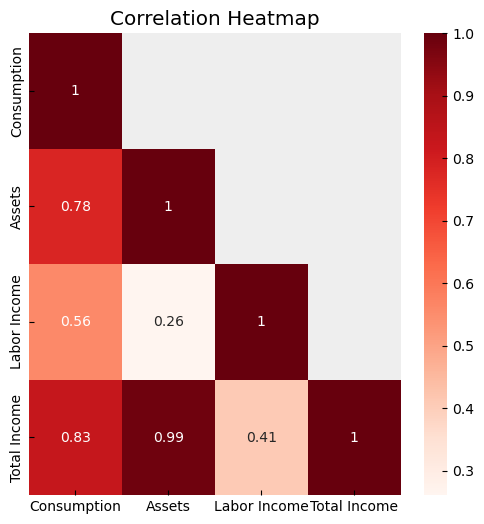

In [91]:
# Exclude the upper triangle of the matrix
# k = 1 keeps the diagonal
mask = np.triu(np.ones_like(correlation_matrix_market, dtype=bool), k=1)

# Heatmap with correlations
## Object
plt.figure(figsize=(6, 6))

## Heatmap: masking (hiding) upper triangle
sns.heatmap(correlation_matrix_market, annot=True, cmap="Reds", mask=mask, 
            xticklabels=heatmap_data.keys(), yticklabels=heatmap_data.keys())

## Aesthetics and showing
plt.title("Correlation Heatmap")
plt.grid(False)
plt.show()

We will now compare the two correlation matrices (obtained here and obtained in ***(b)***).

In [92]:
# Creating DataFrames
correlation_df = pd.DataFrame(correlation_matrix, index=heatmap_data.keys(), columns=heatmap_data.keys())
correlation_df_market = pd.DataFrame(correlation_matrix_market, index=heatmap_data.keys(), columns=heatmap_data.keys())

In [93]:
# Comparing correlation matrices
print(f"r = {annual_interest_rate_previous}")
print(f"{np.around(correlation_df, 2)}")

print(f"\nr = {annual_interest_rate}")
print(f"{np.around(correlation_df_market, 2)}")

print(f"\n(r = {annual_interest_rate}) - (r = {annual_interest_rate_previous})")
print(f"{np.around(correlation_df_market - correlation_df, 2)}")

r = 3.4
              Consumption  Assets  Labor Income  Total Income
Consumption          1.00    0.80          0.38          0.82
Assets               0.80    1.00          0.18          1.00
Labor Income         0.38    0.18          1.00          0.27
Total Income         0.82    1.00          0.27          1.00

r = 2.63
              Consumption  Assets  Labor Income  Total Income
Consumption          1.00    0.78          0.56          0.83
Assets               0.78    1.00          0.26          0.99
Labor Income         0.56    0.26          1.00          0.41
Total Income         0.83    0.99          0.41          1.00

(r = 2.63) - (r = 3.4)
              Consumption  Assets  Labor Income  Total Income
Consumption         -0.00   -0.02          0.18          0.01
Assets              -0.02    0.00          0.08         -0.01
Labor Income         0.18    0.08          0.00          0.14
Total Income         0.01   -0.01          0.14          0.00


The main highlight is the stronger correlation of labor income with total income and consumption: as said before, the lower interest rates makes asset holding less attractive, and so agents buy less of it.

Therefore, labor income fluctuations affect consumption more heavily than before, as they don't use assets to smooth consumption as much as they did before.

### (e) Increasing Risk Aversion

We now increase the risk-aversion from $\sigma = 1.5$ to $\sigma = 3$.

##### (a) Solving the Model

In [94]:
# Initial parameters for the bisection algorithm
q_lb = beta + tol_market_clearing
q_ub = 1.2
q_guess = (q_lb + q_ub) / 2

In [95]:
# Updating the dictionary of parameters
param_dict_market_sigma3 = {
    'beta': beta,
    'sigma': 3,
    'r': 1 / q_guess - 1,
    'q':q_guess,
    'z': 1,
    'T': T
}

In [96]:
# Solving the model
t0 = time.time()
param_dict_market_sigma3, excess_demand_bonds_sigma3, excess_demand_vector_sigma3, \
    policy_a_matrix_sigma3, policy_c_matrix_sigma3, stationary_distribution_sigma3 = \
    market_clearing_huggett(
        param_dict_market_clearing=param_dict_market_sigma3,
        q_lb=q_lb, q_ub=q_ub, q_guess=q_guess,
        asset_grid=asset_grid
    )
print(f"{round(time.time() - t0, 1)} seconds to run.")

 48%|████▊     | 24/50 [00:13<00:14,  1.79it/s]

Algorithm stopped improving. Stopping at 24 iterations.
13.4 seconds to run.


In [97]:
# Printing excess demand
print(f"Excess demand for bonds: {round(excess_demand_bonds_sigma3, 4)}")

Excess demand for bonds: -0.0376


In [98]:
# Printing bond price per period and interest rate per period
print(f"sigma = {sigma}")
print(f"Bond price per period: {round(param_dict_market['q'], 4)}")
print(f"Interest rate per period: {round(100 * param_dict_market['r'], 2)}%")

print(f"\nsigma = 3")
print(f"Bond price per period: {round(param_dict_market_sigma3['q'], 4)}")
print(f"Interest rate per period: {round(100 * param_dict_market_sigma3['r'], 2)}%")

sigma = 1.5
Bond price per period: 0.9957
Interest rate per period: 0.43%

sigma = 3
Bond price per period: 1.0003
Interest rate per period: -0.03%


In [99]:
# Annualized interest rate
annual_interest_rate_sigma3 = round(100 * ((1 + param_dict_market_sigma3['r'])**6 - 1), 2)

print(f"Annual interest rate with sigma = {sigma}: {annual_interest_rate}%")
print(f"Annual interest rate with sigma = 3: {annual_interest_rate_sigma3}%")

Annual interest rate with sigma = 1.5: 2.63%
Annual interest rate with sigma = 3: -0.15%


Note that interest rates are now smaller (and negative) and bond prices are higher than the values we get with $\sigma = 1.5$: a higher risk aversion means agents prefer to smooth consumption, so they buy more bonds; in order for the markets to clear, the price of such bonds must increase, which is equivalent to their returns decreasing.

The result of higher relative risk aversion leading to lower interest rates is also found by Huggett, although he doesn't provide a interpretation for it.

---
Using [MatLab Online](https://matlab.mathworks.com/), Tiago's code gives a bond price of 1.0430 per period and an annual interest rate of -22.31% (per period: -4.12%).

When using the same parameters as his, I get a bond price of 1.0426 per period and an annual interest rate of -22.16% (per period: -4.09%).

Note that this is different from the value in Huggett, which, with a credit limit of -2, gives a bond price of 1.0448 and an annual interest rate of -23% (see Table 2).

---

#### (b) Asset Distribution

In [100]:
# Flattening the policy matrix (first the first column, then the second)
policy_a_flat_sigma3 = policy_a_matrix_sigma3.flatten(order='C')

In [101]:
# Sorting following the values of policy a
sorted_indices_sigma3 = np.argsort(policy_a_flat_sigma3)

sorted_policy_a_flat_sigma3 = policy_a_flat_sigma3[sorted_indices_sigma3]
sorted_stationary_distribution_sigma3 = stationary_distribution_sigma3[0][sorted_indices_sigma3]

In [102]:
# Calculating the CDF
cdf_stationary_distribution_sigma3 = np.cumsum(sorted_stationary_distribution_sigma3)

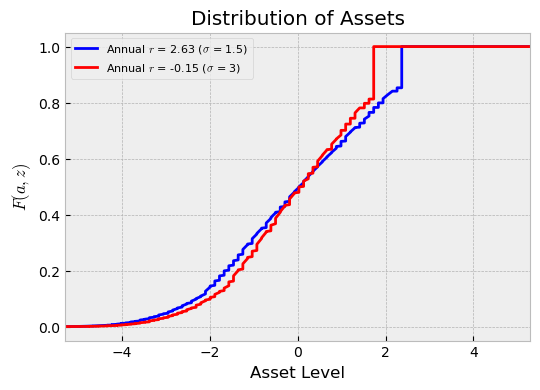

In [103]:
# Plotting
## Object
plt.figure(figsize=(6, 4))

## Plot
### Main result
plt.plot(sorted_policy_a_flat, cdf_stationary_distribution,
         color='blue', label=fr"Annual $r$ = {annual_interest_rate} ($\sigma$ = {sigma})")

### Higher risk aversion
plt.plot(sorted_policy_a_flat_sigma3, cdf_stationary_distribution_sigma3,
         color='red', label=rf"Annual $r$ = {annual_interest_rate_sigma3} ($\sigma$ = 3)")

## Labels
plt.xlabel("Asset Level")
plt.ylabel(r"$F(a, z)$")
plt.title("Distribution of Assets")

## Show
plt.xlim(asset_lb, -asset_lb)  # better visualization
plt.legend(fontsize=8)
plt.grid(True)
plt.show()

We now calculate the Gini coefficient and the standard deviation of asset holdings.

To do so, we will simulate and economy of 10,000 agents that has the same distribution of assets as the stationary one.

In [104]:
# Number of agents
num_agents = 10000

# Array of indexes
array_coefficients_gini_index_sigma3 = np.around(cdf_stationary_distribution_sigma3 * num_agents, 0).astype(int) - 1

# Initializing array
array_assets_agents_sigma3 = np.zeros(num_agents)

# Simulating the distribution
for num_agent in range(num_agents):
    # Grabbing what is the minimum 'quantile' that accomodates that agent
    min_quantile = np.min(array_coefficients_gini_index_sigma3[array_coefficients_gini_index_sigma3 >= num_agent])
    
    # Index of asset
    min_index = np.where(array_coefficients_gini_index_sigma3 == min_quantile)[0][0]

    # Giving that asset level to agent
    array_assets_agents_sigma3[num_agent] = sorted_policy_a_flat_sigma3[min_index]

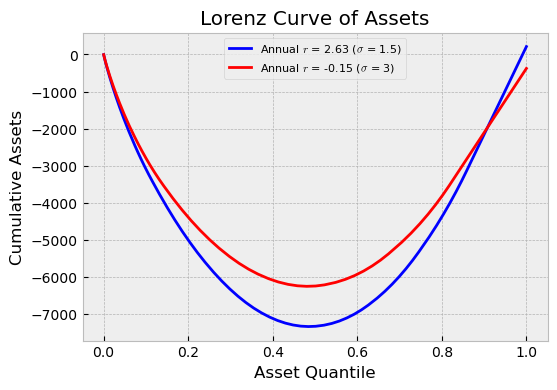

In [105]:
# Calculating Lorenz curve and plotting it
array_assets_lorenz_sigma3 = np.cumsum(array_assets_agents_sigma3)
cumulative_share_agents_sigma3 = np.cumsum(np.ones(num_agents) / num_agents)

## Object
plt.figure(figsize=(6, 4))

## Plot
### Main result
plt.plot(cumulative_share_agents, array_assets_lorenz,
         color='blue', label=fr"Annual $r$ = {annual_interest_rate} ($\sigma$ = {sigma})")

### Higher risk aversion
plt.plot(cumulative_share_agents, array_assets_lorenz_sigma3,
         color='red', label=rf"Annual $r$ = {annual_interest_rate_sigma3} ($\sigma$ = 3)")

## Labels
plt.xlabel("Asset Quantile")
plt.ylabel("Cumulative Assets")
plt.title("Lorenz Curve of Assets")

## Show
plt.legend(fontsize=8)
plt.grid(True)
plt.show()

In [106]:
# Calculating Gini coefficient
print(f"Gini coefficient with sigma = {param_dict_market['sigma']}: {round(gini_coefficient(array_assets_agents), 2)}")
print(f"Gini coefficient with sigma = {param_dict_market_sigma3['sigma']}: {round(gini_coefficient(array_assets_agents_sigma3), 2)}")

Gini coefficient with sigma = 1.5: 46.73
Gini coefficient with sigma = 3: -21.66


In [107]:
# Calculating standard deviation
print(f"Standard deviation with sigma = {param_dict_market['sigma']}: {round(np.std(array_assets_agents), 2)}")
print(f"Standard deviation with sigma = {param_dict_market_sigma3['sigma']}: {round(np.std(array_assets_agents_sigma3), 2)}")

Standard deviation with sigma = 1.5: 1.75
Standard deviation with sigma = 3: 1.44


We see that a higher relative risk aversion leads to a lower standard deviation of asset holdings.
This is because, as seen in the figure with the asset distribution, there is a higher mass of agents at the fixed point, since they want to buy more assets to smooth consumption.

Note that this fixed point is also lower, as too much accumulation of assets also isn't optimal for consumption smoothing.

Therefore, the distribution of wealth as measured by assets is less dispersed.

### (f) Decreasing the Borrowing Constraint

We will decrease the absolute value of the borrowing constraint by half.

#### Solving the Model

In [108]:
# Updating parameter
asset_lb_half = asset_lb / 2

# Creating new grid
asset_grid_half = np.linspace(asset_lb_half, asset_up, num_states_assets)

In [109]:
# Initial parameters for the bisection algorithm
q_lb = beta + tol_market_clearing
q_ub = 1.2
q_guess = (q_lb + q_ub) / 2

# Updating the dictionary of parameters
param_dict_market_half = {
    'beta': beta,
    'sigma': sigma,
    'r': 1 / q_guess - 1,
    'q':q_guess,
    'z': 1,
    'T': T
}

In [110]:
# Solving the model
t0 = time.time()
param_dict_market_half, excess_demand_bonds_half, excess_demand_vector_half, \
    policy_a_matrix_half, policy_c_matrix_half, stationary_distribution_half \
    = market_clearing_huggett(
        param_dict_market_clearing=param_dict_market_half,
        q_lb=q_lb, q_ub=q_ub, q_guess=q_guess,
        asset_grid=asset_grid_half,
        max_iter_market_clearing=80
    )
print(f"{round(time.time() - t0, 1)} seconds to run.")

  0%|          | 0/80 [00:00<?, ?it/s]

 69%|██████▉   | 55/80 [00:33<00:15,  1.66it/s]

Algorithm stopped improving. Stopping at 55 iterations.
33.2 seconds to run.


In [111]:
# Printing excess demand
print(f"Excess demand for bonds: {round(excess_demand_bonds_half, 4)}")

Excess demand for bonds: -0.0124


In [112]:
# Printing bond price per period and interest rate per period
# Printing bond price per period and interest rate per period
print(f"Borrowing constraint = {round(asset_lb, 2)}")
print(f"Bond price per period: {round(param_dict_market['q'], 4)}")
print(f"Interest rate per period: {round(100 * param_dict_market['r'], 2)}%")

print(f"\nBorrowing constraint = {round(asset_lb_half, 2)}")
print(f"Bond price per period: {round(param_dict_market_half['q'], 4)}")
print(f"Interest rate per period: {round(100 * param_dict_market_half['r'], 2)}%")

Borrowing constraint = -5.3
Bond price per period: 0.9957
Interest rate per period: 0.43%

Borrowing constraint = -2.65
Bond price per period: 1.0031
Interest rate per period: -0.31%


In [113]:
# Annualized interest rate
# Annualized interest rate
annual_interest_rate_half = round(100 * ((1 + param_dict_market_half['r'])**6 - 1), 2)

print(f"Annual interest rate with borrowing constraint = {round(asset_lb, 2)}: {annual_interest_rate}%")
print(f"Annual interest rate with borrowing constraint = {round(asset_lb_half, 2)}: {annual_interest_rate_half}%")

Annual interest rate with borrowing constraint = -5.3: 2.63%
Annual interest rate with borrowing constraint = -2.65: -1.87%


With the lower borrowing constraint, interest rates are now negative.
This is consistent with the findings in Huggett's original paper, with interest rates being below zero for $\underline{a} = -2$ and positive for higher borrowing constraints ($-4$, $-6$ and so on).

Following Huggett, the intuition behind the result is that, as the credit limit increases (in absolute value), the interest rate must also increase to prevent agents from accumulating large debts.
Only in this way does the bond market clear.

#### Asset Distributions

In [114]:
# Flattening the policy matrix (first the first column, then the second)
policy_a_flat_half = policy_a_matrix_half.flatten(order='C')

In [115]:
# Sorting following the values of policy a
sorted_indices_half = np.argsort(policy_a_flat_half)

sorted_policy_a_flat_half = policy_a_flat_half[sorted_indices_half]
sorted_stationary_distribution_half = stationary_distribution_half[0][sorted_indices_half]

In [116]:
# Calculating the CDF
cdf_stationary_distribution_half = np.cumsum(sorted_stationary_distribution_half)

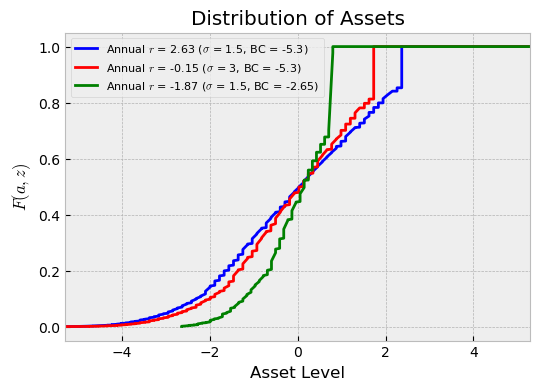

In [117]:
# Plotting
## Object
plt.figure(figsize=(6, 4))

## Plot
### Main result
plt.plot(sorted_policy_a_flat, cdf_stationary_distribution,
         color='blue', 
         label=fr"Annual $r$ = {annual_interest_rate} ($\sigma$ = {sigma}, BC = {round(asset_lb, 2)})")

### Higher risk aversion
plt.plot(sorted_policy_a_flat_sigma3, cdf_stationary_distribution_sigma3,
         color='red', 
         label=rf"Annual $r$ = {annual_interest_rate_sigma3} ($\sigma$ = 3, BC = {round(asset_lb, 2)})")

### Lower borrowing constraint
plt.plot(sorted_policy_a_flat_half, cdf_stationary_distribution_half,
         color='green', 
         label=fr"Annual $r$ = {annual_interest_rate_half} ($\sigma$ = {sigma}, BC = {round(asset_lb_half, 2)})")

## Labels
plt.xlabel("Asset Level")
plt.ylabel(r"$F(a, z)$")
plt.title("Distribution of Assets")

## Show
plt.xlim(asset_lb, -asset_lb)  # better visualization
plt.legend(fontsize=8)
plt.grid(True)
plt.show()

We now calculate the Gini coefficient and the standard deviation of asset holdings.

To do so, we will simulate and economy of 10,000 agents that has the same distribution of assets as the stationary one.

In [118]:
# Number of agents
num_agents = 10000

# Array of indexes
array_coefficients_gini_index_half = np.around(cdf_stationary_distribution_half * num_agents, 0).astype(int) - 1

# Initializing array
array_assets_agents_half = np.zeros(num_agents)

# Simulating the distribution
for num_agent in range(num_agents):
    # Grabbing what is the minimum 'quantile' that accomodates that agent
    min_quantile = np.min(array_coefficients_gini_index_half[array_coefficients_gini_index_half >= num_agent])
    
    # Index of asset
    min_index = np.where(array_coefficients_gini_index_half == min_quantile)[0][0]

    # Giving that asset level to agent
    array_assets_agents_half[num_agent] = sorted_policy_a_flat_half[min_index]

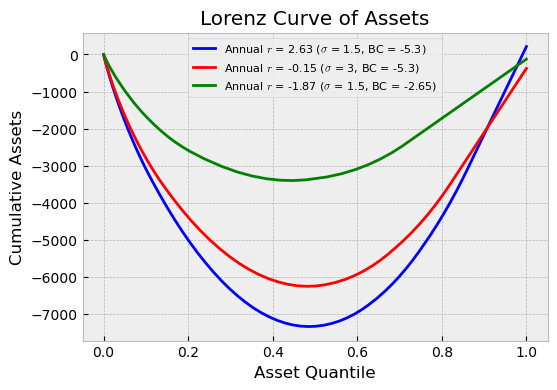

In [119]:
# Calculating Lorenz curve and plotting it
array_assets_lorenz_half = np.cumsum(array_assets_agents_half)
cumulative_share_agents_half = np.cumsum(np.ones(num_agents) / num_agents)

## Object
plt.figure(figsize=(6, 4))

## Plot
### Main result
plt.plot(cumulative_share_agents, array_assets_lorenz,
         color='blue', 
         label=fr"Annual $r$ = {annual_interest_rate} ($\sigma$ = {sigma}, BC = {round(asset_lb, 2)})")

### Higher risk aversion
plt.plot(cumulative_share_agents_sigma3, array_assets_lorenz_sigma3,
         color='red', 
         label=rf"Annual $r$ = {annual_interest_rate_sigma3} ($\sigma$ = 3, BC = {round(asset_lb, 2)})")

### Lower borrowing constraint
plt.plot(cumulative_share_agents_half, array_assets_lorenz_half,
         color='green',
         label=fr"Annual $r$ = {annual_interest_rate_half} ($\sigma$ = {sigma}, BC = {round(asset_lb_half, 2)})")

## Labels
plt.xlabel("Asset Quantile")
plt.ylabel("Cumulative Assets")
plt.title("Lorenz Curve of Assets")

## Show
plt.grid(True)
plt.legend(fontsize=8)
plt.show()

In [120]:
# Calculating Gini coefficient
print(f"Gini coefficient with BC = {round(asset_lb, 2)}: {round(gini_coefficient(array_assets_agents), 2)}")
print(f"Gini coefficient with sigma = {param_dict_market_sigma3['sigma']}: {round(gini_coefficient(array_assets_agents_sigma3), 2)}")
print(f"Gini coefficient with BC = {round(asset_lb_half, 2)}: {round(gini_coefficient(array_assets_agents_half), 2)}")

Gini coefficient with BC = -5.3: 46.73
Gini coefficient with sigma = 3: -21.66
Gini coefficient with BC = -2.65: -35.37


In [121]:
# Calculating standard deviation
print(f"Standard deviation with BC = {round(asset_lb, 2)}: {round(np.std(array_assets_agents), 2)}")
print(f"Standard deviation with sigma = {param_dict_market_sigma3['sigma']}: {round(np.std(array_assets_agents_sigma3), 2)}")
print(f"Standard deviation with BC = {round(asset_lb_half, 2)}: {round(np.std(array_assets_agents_half), 2)}")

Standard deviation with BC = -5.3: 1.75
Standard deviation with sigma = 3: 1.44
Standard deviation with BC = -2.65: 0.8


A smaller borrowing constraint leads to a (much) lower standard deviation of assets.
This can be attributed to two effects, both visible in the figure with the CDF of the asset distributions:

1. Agents are limited in how much they can borrow, so the left-tail of the distribution is shifted to right, which leads to less dispersion;
2. A higher mass of agents is at the fixed point, which is at a smaller asset value when compared to the other two distributions (see graph of the policy function below). This shifts the right-tail of the distribution to the left, which also leads to less dispersion.

The question is: why is the fixed point smaller?
That is a very good question and one I couldn't come up with an answer... maybe because agents can't borrow as much, so they can't smooth consumption as they want, and so adjust to a higher permanent consumption level through less asset buying? 

Another possibility is that the lower interest rate caused by the borrowing constraint makes it so that asset buying isn't as attractive, and so agents don't accumulate as many assets as they did before.

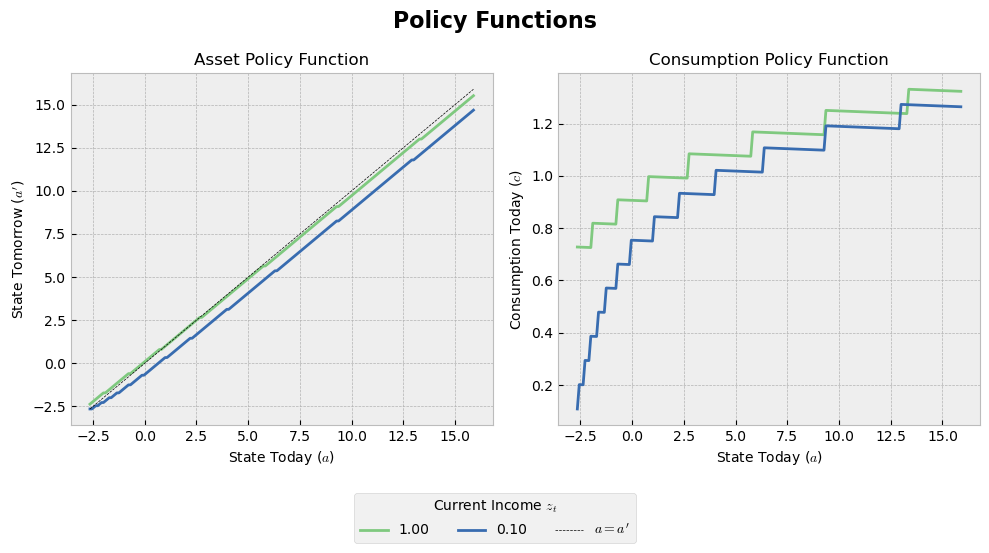

In [122]:
plot_policy_uncertainty(asset_grid_half, policy_a_matrix_half, 
                        policy_c_matrix_half, income_grid)